In [4]:
#!pip install pandas_datareader

In [1]:
# importar bibliotecas
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import random
import datetime

import investpy
import mplfinance as mpf
import matplotlib.pyplot as plt
import math
import scipy as sco 
from scipy import stats
import matplotlib.ticker as mtick
from datetime import date, datetime, timedelta
import seaborn as sns

In [2]:
#Esta função busca dos dados de açoes e fii no site FUNDAMENTUS e cria 2 arquivos em excel
hoje = date.today()

def baixar_dados_AC_and_FII():
    
    # Busca no site fundamentus

    url = 'https://www.fundamentus.com.br/resultado.php'
    urlfii = 'https://www.fundamentus.com.br/fii_resultado.php'

    agent = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}

    resposta = requests.get(url, headers= agent)
    respostafii = requests.get(urlfii, headers= agent)

    soup = BeautifulSoup(resposta.text, 'lxml')
    soupfii = BeautifulSoup(respostafii.text, 'lxml')

    tabela = soup.find_all('table')[0]
    tabelafii = soupfii.find_all('table')[0]

    df = pd.read_html(str(tabela), decimal=',', thousands='.')[0]
    dfii = pd.read_html(str(tabelafii), decimal=',', thousands='.')[0]


    # Lista de colunas de Ações com %
    colunas = ['Div.Yield','ROIC','Mrg Ebit','Mrg. Líq.','ROE','Cresc. Rec.5a']

    # Loop for para processar cada coluna
    for coluna in colunas:
        df[coluna] = df[coluna].str.replace("%", "", regex=False)
        df[coluna] = df[coluna].str.replace(".", "", regex=False)
        df[coluna] = df[coluna].str.replace(",", ".", regex=False)
        df[coluna] = df[coluna].astype(float)


    # Lista de colunas de Fiis com %
    colunasf = ['Dividend Yield','FFO Yield','Vacância Média','Cap Rate']

    # Loop for para processar cada coluna
    for coluna in colunasf:
        dfii[coluna] = dfii[coluna].str.replace("%", "", regex=False)
        dfii[coluna] = dfii[coluna].str.replace(".", "", regex=False)
        dfii[coluna] = dfii[coluna].str.replace(",", ".", regex=False)
        dfii[coluna] = dfii[coluna].astype(float)

    df.to_excel('dadosAções.xlsx', index=False)
    dfii.to_excel('dadosFii.xlsx', index=False)
    
    #dfcarteirahj = 'dadosAções_' + str(hoje) + '.xlsx'
    #dfiicarteirahj = 'dadosFii_' + str(hoje) + '.xlsx'
    #df.to_excel(dfcarteirahj, index=False)
    #dfii.to_excel(dfiicarteirahj, index=False)
    return df
    
def formula_magica():

    # Filtros no data frame de Ações

    Cot = df[df['Cotação'] <= 100]
    #Cot = Cot[Cot['Mrg. Líq.'] >= 5]

    maiorLiquidez = Cot[Cot['Liq.2meses'] >= 1000000]
    maiorLiquidez = maiorLiquidez[maiorLiquidez['P/L']>0]
    maiorLiquidez = maiorLiquidez[maiorLiquidez['ROE']>9]
    
    #patrimonioLiquido = maiorLiquidez[maiorLiquidez['Patrim. Líq'] >= 0]
    #roic = patrimonioLiquido[patrimonioLiquido['ROE'] >= 0]
    #roic = roic[roic['EV/EBIT'] >= 0]
    #EVEBIT = EVEBIT[EVEBIT['Cresc. Rec.5a'] >=0]
    #EVEBIT

    novo = maiorLiquidez[['Papel', 'Cotação', 'Div.Yield' , 'P/L', 'ROE', 'Cresc. Rec.5a', 'Mrg. Líq.']]


    # Aplicação da fórmula nas ações

    Oev = novo.sort_values(by = 'P/L')
    Oev = Oev.reset_index(drop = True)
    Oev['Ordem P/L'] = Oev.index

    Oroic = Oev.sort_values(by = 'ROE', ascending= False)
    Oroic = Oroic.reset_index(drop = True)
    Oroic['Ordem ROE'] = Oroic.index
    dados = Oroic

    dados['Score'] = dados['Ordem P/L'] + dados['Ordem ROE']
    dados = dados.sort_values(by = 'Score', ascending= True)
    
    #Remove os Tickers duplicados
    dados['PapelF'] = dados['Papel'].str[:4]
    dados = dados.drop_duplicates(subset='PapelF')

    Ac = dados[['Papel', 'Cotação', 'Div.Yield' , 'P/L', 'Cresc. Rec.5a', 'Mrg. Líq.']]

    #dados['Prec. Compra'] = dados['Cotação'] * dados['Div.Yield']/6 * 0.9
    #dados['Prec. Venda'] = dados['Cotação'] * dados['Div.Yield']/6 * 1.2

    Ac.reset_index(inplace=True)
    Ac = Ac.drop('index', axis=1)
    
    Ac.to_excel('Ações_Mágicas.xlsx', index=False)
    carteirahj = 'Ações_Mágicas_' + str(hoje) + '.xlsx'
    Ac.to_excel(carteirahj, index=False)
    
    return Ac
    
def formula_fii():

    # Rodar essa parte apenas em datas específicas

    # Filtros no data frame de Fii

    #Cotacao = dfii[dfii['Cotação'] <= 200]
    #Liq = Cotacao[Cotacao['Liquidez'] >= 1000000]
    #Vaq = Liq[Liq['Vacância Média'] <= 7]
    Vaq = dfii[(dfii['Cotação'] <= 300) & (dfii['Liquidez'] >= 900000) & (dfii['Vacância Média'] <= 7)]
    
    # Aplicação da fórmula de Fii Hibrid

    FiiT = Vaq[Vaq['Qtd de imóveis'] >= 5]
    FiiT = FiiT[['Papel', 'Segmento', 'Cotação','Dividend Yield', 'FFO Yield', 'P/VP', 'Valor de Mercado', 'Qtd de imóveis']]

    Opvp = FiiT.sort_values(by = 'P/VP', ascending= True)
    Opvp = Opvp.reset_index(drop = True)
    Opvp['Ordem P/VP'] = Opvp.index

    Offo = Opvp.sort_values(by = 'FFO Yield', ascending= False)
    Offo = Offo.reset_index(drop = True)
    Offo['Ordem FFO Yield'] = Offo.index

    Offo['Score'] = Offo['Ordem P/VP'] + Offo['Ordem FFO Yield']
    FiiT = Offo.sort_values(by = 'Score', ascending= True)

    FiiT = FiiT[['Papel', 'Segmento', 'Cotação','Dividend Yield', 'P/VP','Qtd de imóveis']]

    FiiT.reset_index(inplace=True)
    FiiT.drop('index', axis=1, inplace = True)
    
    FiiT.to_excel('Fii_Tij_Hibrid_Mágicas.xlsx', index=False)
    Fiicarteirahj = 'Fii_Tij_Hibrid_Mágicas_' + str(hoje) + '.xlsx'
    FiiT.to_excel(Fiicarteirahj, index=False)
    
    # Rodar essa parte apenas em datas específicas

    # Aplicação da fórmula de Fii Papel

    FiiP = Vaq[(Vaq['Qtd de imóveis'] <= 0) & (Vaq['P/VP'] >= 0.50)]
    #FiiP = FiiP[FiiP['P/VP'] >= 0.50]

    FiiP = FiiP[['Papel', 'Segmento', 'Cotação', 'FFO Yield', 'Dividend Yield', 'P/VP', 'Valor de Mercado']]

    Opvp = FiiP.sort_values(by = 'P/VP', ascending= True)
    Opvp = Opvp.reset_index(drop = True)
    Opvp['Ordem P/VP'] = Opvp.index

    Offo = Opvp.sort_values(by = 'FFO Yield', ascending= False)
    Offo = Offo.reset_index(drop = True)
    Offo['Ordem FFO Yield'] = Offo.index

    Offo['Score'] = Offo['Ordem P/VP'] + Offo['Ordem FFO Yield']
    FiiP = Offo.sort_values(by = 'Score', ascending= True)

    FiiP = FiiP[['Papel', 'Segmento', 'Cotação','Dividend Yield', 'P/VP']]

    FiiP.reset_index(inplace=True)
    FiiP.drop('index', axis=1, inplace = True)
    FiiP.to_excel('Fii_Papel_Mágicas.xlsx', index=False)
    FiiPcarteirahj = 'Fii_Papel_Mágicas_' + str(hoje) + '.xlsx'
    FiiP.to_excel(FiiPcarteirahj, index=False)
    
    return FiiT

def hist_dividendos_5anos(Ac):
    
    # histórico de dividendos das ações
    tickers = Ac.loc[:,'Papel']+".SA"

    dividendos = []
    segmento = []
    setor = []

    for ticker in tickers:
        div6 = []

        try:
            div = yf.Ticker(ticker).dividends
            setr = yf.Ticker(ticker).info['sector']
            seg = yf.Ticker(ticker).info['industry']

        except Exception as e:
            print(f"Erro ao obter dividendos para {ticker}: {e}")
            y = 0
            dividendos.append(y)
            setor.append(y)
            segmento.append(y)

        else:

            anos = ['2023','2022', '2021', '2019', '2018']
            div6 = []  
            # Lista para os dividendos dos últimos 6 anos
            for x in anos:
                if x in div:
                    div6.append(div[x].sum())
                else:
                    div6.append(0)
            y = sum(div6)
            dividendos.append(y)
            setor.append(setr)
            segmento.append(seg)
            

    Ac['Div. 5A'] = dividendos
    Ac['PJ'] = (Ac['Div. 5A']/5)/0.06
    Ac['Setor'] = setor
    Ac['Segmento'] = segmento
    
    Ac.to_excel('Ações_Mágicas.xlsx', index=False)
    #carteirahj = 'Ações_Mágicas_' + str(hoje) + '.xlsx'
    #Ac.to_excel(carteirahj, index=False)
        
    return Ac

def hist_cotacao(qtde_anos, qtde_acoes, Ac):
    # seleciona o período para o histórico de cotações
    today = hoje
    data_hoje = today.strftime("%d/%m/%Y") # data de hoje em formato brasileiro
    date_today = today.strftime("%Y-%m-%d")  # data de hoje em formato brasileiro
    inicio = datetime.now() + timedelta(days=(-365.25*qtde_anos)) # data inicial volta para 'qtde_anos' anos atrás
    data_inicio = inicio.strftime("%d/%m/%Y")  # data de hoje em formato brasileiro
    date_start = inicio.strftime("%Y-%m-%d") # data de hoje em formato amerciano
    
    # seleciona as ações da lista escolhida
    tickers = Ac.head(qtde_acoes)['Papel'] + '.SA'
    
    #3. Importando histórico de ações
    precos = pd.DataFrame()

    for i in tickers:
      ticker = yf.Ticker(i)
      precos[i] = ticker.history(start=date_start, end=date_today)["Close"]
    
    #novo_nome = []
    #for i in range(len(tickers)):
    #  elemento = str(tickers[i][:tickers[i].find('.SA')]) # elimina o '.SA'
    #  novo_nome.append(elemento)

    #precos.columns = novo_nome
    
    return precos

def graf_hist(precos):
    
    #Transformando o histórico para base 100
    preco_100 = (precos/precos.iloc[0]*100) # trava no primeiro registro da série
    
    df = preco_100
    fig, ax = plt.subplots(figsize=[12, 7])

    for col in df.columns:
      plt.plot(df[col], label=col) # label com a coluna do dataframe
       
    plt.xticks(rotation=45)
    ax.set_title('Comparação de ativos padronizados na base 100', fontsize=18)
    ax.set_xlabel('Período')
    ax.set_ylabel('Preços base 100')
    plt.legend()
    plt.show()
    
def correlacao(precos):
    retornos = precos.pct_change().dropna() # retirar registros com 'NaN'
    rotulo= retornos.columns.to_list()
    e_r=retornos.mean()
    vol=retornos.std()
    #mat_cov=retornos.cov()
    print(e_r.mean()*100)
    print(vol.mean()*100)
    # Calcular a matriz de correlação
    matriz_correlacao = retornos.corr()
    
    # Criar um gráfico maior
    plt.figure(figsize=(10, 8))

    # Criar um mapa de calor (heatmap) usando Seaborn
    sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")

    # Exibir o gráfico
    plt.show()

In [3]:
baixar_dados_AC_and_FII()
df = pd.read_excel('dadosAções.xlsx')
dfii = pd.read_excel('dadosFii.xlsx')

Ac = formula_magica()
Ac = hist_dividendos_5anos(Ac)
fii = formula_fii()

JPSA3.SA: No timezone found, symbol may be delisted


Erro ao obter dividendos para JPSA3.SA: 'sector'


In [4]:
Aux = Ac[(Ac['Setor'] != 'Real Estate') & (Ac['Segmento'] != 'Household & Personal Products')]
Aux.to_excel('Ações_Mágicas.xlsx', index=False)

In [5]:
Aux.head(20).describe(include='all')

,Papel,Cotação,Div.Yield,P/L,Cresc. Rec.5a,Mrg. Líq.,Div. 5A,PJ,Setor,Segmento
count,20,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20,20
unique,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,16
top,SUZB3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Basic Materials,Paper & Paper Products
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2
mean,NaN,25.991500,8.471500,6.509500,20.926500,18.262500,7.970081,26.566938,NaN,NaN
std,NaN,20.267338,6.480755,1.605528,15.880437,11.960217,9.462805,31.542684,NaN,NaN
min,NaN,4.360000,0.160000,3.680000,0.000000,0.000000,0.072644,0.242147,NaN,NaN
25%,NaN,10.782500,4.520000,5.412500,11.577500,12.660000,0.907450,3.024834,NaN,NaN
50%,NaN,20.175000,7.620000,6.670000,18.390000,16.095000,4.241424,14.138082,NaN,NaN
75%,NaN,38.650000,9.227500,7.620000,24.890000,24.020000,11.445283,38.150943,NaN,NaN


In [10]:
#Ac = pd.read_excel('Ações_Mágicas.xlsx')
#Ac['Setor'].unique()

In [11]:
#Ac[Ac['Setor'] == 'Consumer Cyclical']

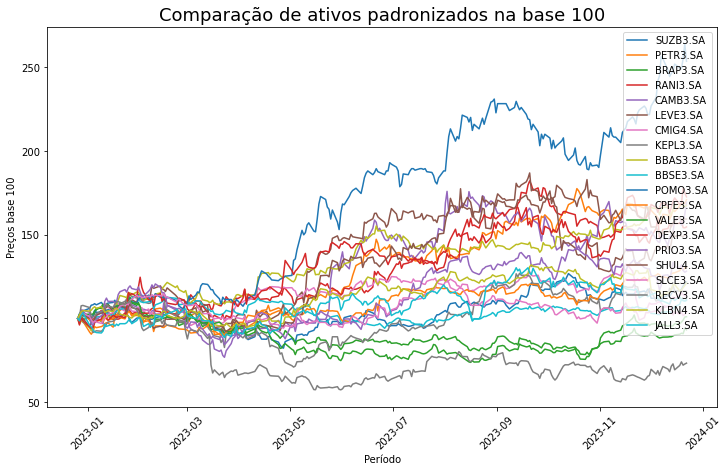

In [6]:
precos = hist_cotacao(1,20,Aux)
graf_hist(precos)

0.13108128698829974
2.0142146912090695


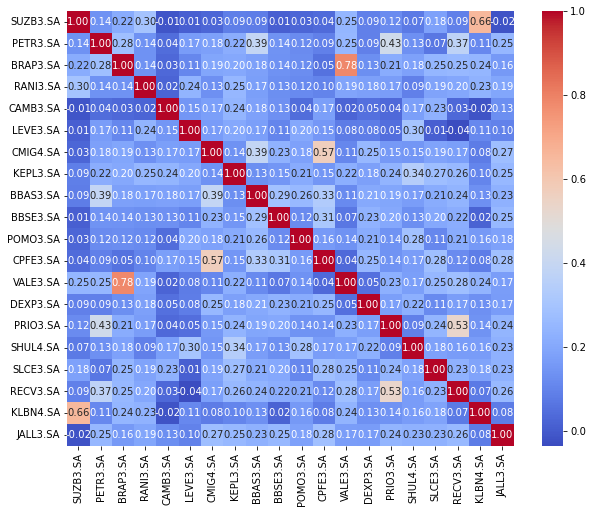

In [7]:
correlacao(precos)
